This script analize the inventory items dataset to understand if there are any critical issues in the dataset or in the storage to improve the storage management.

In [1]:
#library import
import pandas as pd
import matplotlib.pyplot as plt

**Dataset definition**

In [2]:
#upload and dataset visualization
df_inventory_items = pd.read_csv("inventory_items_cleaned.csv")
df_distribution_centers = pd.read_csv("distribution_centers_cleaned.csv")
df_products = pd.read_csv("products_cleaned.csv")
df_order_items = pd.read_csv("order_items_cleaned.csv")
df_order= pd.read_csv("orders_cleaned.csv")

In [3]:
print(df_inventory_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488651 entries, 0 to 488650
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   inventory_item_id     488651 non-null  int64  
 1   product_id            488651 non-null  int64  
 2   created_at            488651 non-null  object 
 3   sold_at               180858 non-null  object 
 4   cost                  488651 non-null  float64
 5   product_retail_price  488651 non-null  float64
 6   center_id             488651 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ MB
None


In [ ]:
#merging df_inventory_items with df_distribution_centers
df_inventory = df_inventory_items.merge(df_distribution_centers[['center_id','center_name','latitude','longitude']], on='center_id', how='left')

In [ ]:
# merging inventory with product attributes
df_inventory_static = df_inventory.merge(df_products[['product_id','category','name','brand','department']], on='product_id', how='left')

In [6]:
#change the data type of the created_at and sold_at columns to datetime
df_inventory_static['created_at'] = pd.to_datetime(df_inventory_static['created_at'])
df_inventory_static['sold_at'] = pd.to_datetime(df_inventory_static['sold_at'])

In [7]:
#Creating collums to understand how much items stay in invetory
df_inventory_static['days_in_inventory_total'] = (
    df_inventory_static['sold_at'].fillna(pd.Timestamp('2026-02-25 00:06:11')) - df_inventory_static['created_at']
).dt.days
df_inventory_static['days_in_inventory_sold'] = (
    df_inventory_static['sold_at'] - df_inventory_static['created_at']
).dt.days

In [8]:
#df_order_last dataframe creation
df_order_last = (df_order_items.sort_values(['inventory_item_id', 'created_at']).groupby('inventory_item_id').tail(1).copy())

In [9]:
for col in ['shipped_at', 'delivered_at', 'returned_at']:
    df_order_last[col] = pd.to_datetime(df_order_last[col])

In [10]:
df_inventory_static2 = df_inventory_static.merge(df_order_last[['inventory_item_id','order_id','items_status','shipped_at','delivered_at','returned_at','sale_price']],
                                                 on='inventory_item_id', how='left')

In [11]:
def classify_status(row):
    
    # 1. Returned
    if pd.notna(row['returned_at']):
        return 'returned'
    
    # 2. Delivered
    if pd.notna(row['delivered_at']):
        return 'delivered'
    
    # 3. Shipped
    if pd.notna(row['shipped_at']):
        return 'shipped'
    
    # 4. Sold but not shipped
    if pd.notna(row['sold_at']) and pd.isna(row['shipped_at']):
        return 'sold_not_shipped'
    
    # 5. Processing / assigned / pending
    if isinstance(row['items_status'], str):
        status = row['items_status'].lower()
        if 'process' in status or 'assign' in status or 'pending' in status:
            return 'processing'
    
    # 6. Available (never sold)
    if pd.isna(row['sold_at']):
        return 'available'
    
    return 'unknown'
df_inventory_static2['operational_status'] = df_inventory_static2.apply(classify_status, axis=1)

In [12]:
#Ghost inventory classification
df_inventory_static2['is_ghost'] = (
    (df_inventory_static2['operational_status'] == 'available') &
    (df_inventory_static2['days_in_inventory_total'] > 365) &
    (df_inventory_static2['items_status'].isna()) &
    (df_inventory_static2['sale_price'].isna()))

In [13]:
df_inventory_static3 = df_inventory_static2.merge(df_order[['order_id', 'order_status']], on='order_id', how='left')

In [14]:
df_real = df_inventory_static3[df_inventory_static3['is_ghost'] == False].copy()

In [15]:
print(df_real.info())

<class 'pandas.core.frame.DataFrame'>
Index: 382070 entries, 0 to 488650
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   inventory_item_id        382070 non-null  int64         
 1   product_id               382070 non-null  int64         
 2   created_at               382070 non-null  datetime64[ns]
 3   sold_at                  180858 non-null  datetime64[ns]
 4   cost                     382070 non-null  float64       
 5   product_retail_price     382070 non-null  float64       
 6   center_id                382070 non-null  int64         
 7   center_name              382070 non-null  object        
 8   latitude                 382070 non-null  float64       
 9   longitude                382070 non-null  float64       
 10  category                 382070 non-null  object        
 11  name                     382054 non-null  object        
 12  brand                

In [16]:
df_real.to_csv('inventory_items_centere_and_products.csv', index=False)  

**KPI (key performance indicators) metrics**

**Stoks metriocs**

In [17]:
#percentage of ghost
print(f"Percentage of ghost inventory: {df_inventory_static3['is_ghost'].mean()*100:.2f}%")

Percentage of ghost inventory: 21.81%


In [18]:
#Item ghost cancelled
ghost_cancelled = (
    (df_inventory_static3['sold_at'].notna()) &
    (df_inventory_static3['order_status'] == 'Cancelled')
)
print('Item ghost cancelled')
print(ghost_cancelled.value_counts())

Item ghost cancelled
False    488651
Name: count, dtype: int64


In [19]:
#Item ghost return mismatch
ghost_return_mismatch = (
    (df_inventory_static3['returned_at'].notna()) &
    (df_inventory_static3['operational_status'] != 'returned')
)
print('Item ghost return mismatch')
print(ghost_return_mismatch.value_counts())

Item ghost return mismatch
False    488651
Name: count, dtype: int64


In [20]:
#Item ghost missing order item
ghost_missing_order_item = (
    (df_inventory_static3['sold_at'].notna()) &
    (df_inventory_static3['sale_price'].isna())
)
print('#Item ghost missing order item')
print(ghost_missing_order_item.value_counts())

#Item ghost missing order item
False    307793
True     180858
Name: count, dtype: int64


In [21]:
#Item ghost sold not shipped
ghost_sold_not_shipped = (
    (df_inventory_static3['sold_at'].notna()) &
    (df_inventory_static3['shipped_at'].isna()) &
    (df_inventory_static3['order_status'] != 'Cancelled')
)

print('Item ghost sold not shipped')
print(ghost_sold_not_shipped.value_counts())

Item ghost sold not shipped
False    307793
True     180858
Name: count, dtype: int64


In [ ]:
#Item ghost shipped not delivered
ghost_shipped_not_delivered = (
    (df_inventory_static3['shipped_at'].notna()) &
    (df_inventory_static3['delivered_at'].isna()) &
    (df_inventory_static3['returned_at'].isna()) &
    (df_inventory_static3['order_status'] != 'Cancelled')
)
print(ghost_shipped_not_delivered.value_counts())

False    434281
True      54370
Name: count, dtype: int64


In [22]:
#Percentage of ghost per category
print(df_inventory_static3.groupby('category')['is_ghost'].mean().sort_values(ascending=False))

category
Skirts                           0.225189
Blazers & Jackets                0.225040
Jumpsuits & Rompers              0.223164
Outerwear & Coats                0.222403
Socks & Hosiery                  0.221794
Pants & Capris                   0.221438
Socks                            0.220496
Intimates                        0.219789
Active                           0.219155
Fashion Hoodies & Sweatshirts    0.219024
Leggings                         0.218928
Tops & Tees                      0.218888
Sleep & Lounge                   0.217961
Accessories                      0.217487
Sweaters                         0.217142
Underwear                        0.216667
Shorts                           0.216521
Jeans                            0.216514
Dresses                          0.216467
Plus                             0.216134
Suits & Sport Coats              0.216081
Pants                            0.215881
Swim                             0.215498
Suits                    

In [23]:
#ghost per center
print(df_inventory_static3.groupby('center_name')['is_ghost'].mean().sort_values(ascending=False))

center_name
Charleston SC                                  0.220258
Philadelphia PA                                0.220196
Chicago IL                                     0.219792
Los Angeles CA                                 0.219110
Port Authority of New York/New Jersey NY/NJ    0.218738
Houston TX                                     0.217438
New Orleans LA                                 0.217286
Mobile AL                                      0.216599
Savannah GA                                    0.215895
Memphis TN                                     0.215773
Name: is_ghost, dtype: float64


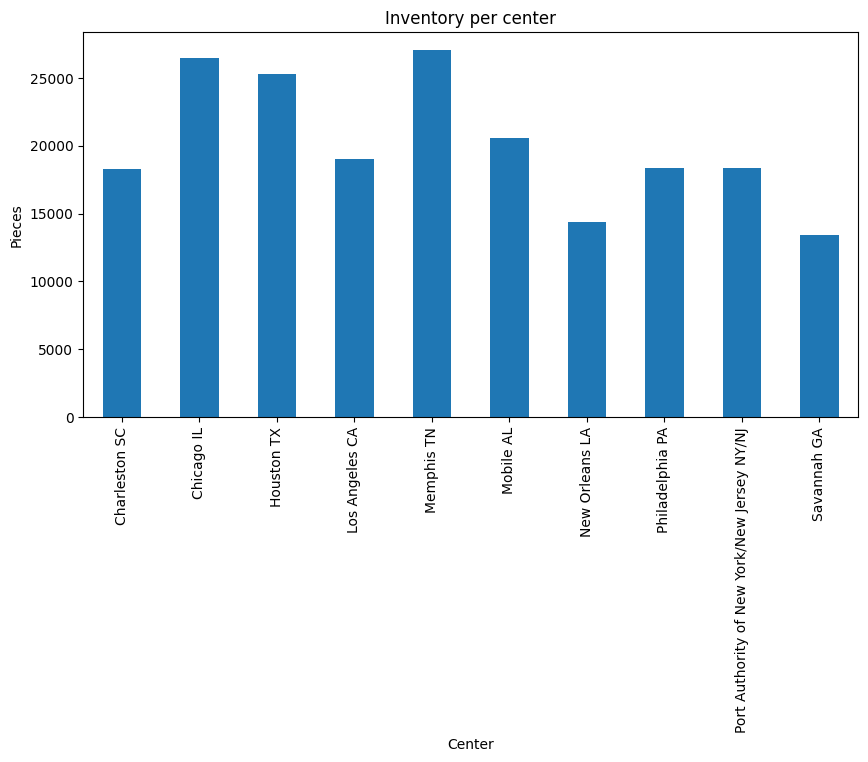

Centers with higher inventory all:
center_name
Memphis TN        27017
Chicago IL        26446
Houston TX        25284
Mobile AL         20590
Los Angeles CA    19006
dtype: int64

Centers with lower inventory all:
center_name
Savannah GA                                    13452
New Orleans LA                                 14399
Charleston SC                                  18317
Port Authority of New York/New Jersey NY/NJ    18322
Philadelphia PA                                18379
dtype: int64


In [24]:
#stock per center
stock_per_center = (df_real[df_real['sold_at'].isna()].groupby('center_name').size())

stock_per_center.plot(kind='bar', figsize=(10,5))
plt.title("Inventory per center")
plt.xlabel("Center")
plt.ylabel("Pieces")
plt.show()

print("Centers with higher inventory all:")
print(stock_per_center.sort_values(ascending=False).head())
print("\nCenters with lower inventory all:")
print(stock_per_center.sort_values(ascending=True).head())

In [25]:
#stock per brand 
stock_brand = df_real.groupby('brand').size()

print("Brand with higher stocks per brand:")
print(stock_brand.sort_values(ascending=False).head())
print("\nBrand with lower stoks per brand:")
print(stock_brand.sort_values(ascending=True).head())

Brand with higher stocks per brand:
brand
Allegra K       12854
Calvin Klein     7005
Carhartt         5405
Hanes            4110
Volcom           3920
dtype: int64

Brand with lower stoks per brand:
brand
Teezâˆ’Her       2
Blancq-Olibet    2
EcoGirl          2
Tabi Socks       2
FLATSEVEN        2
dtype: int64


**Inventory metrics**

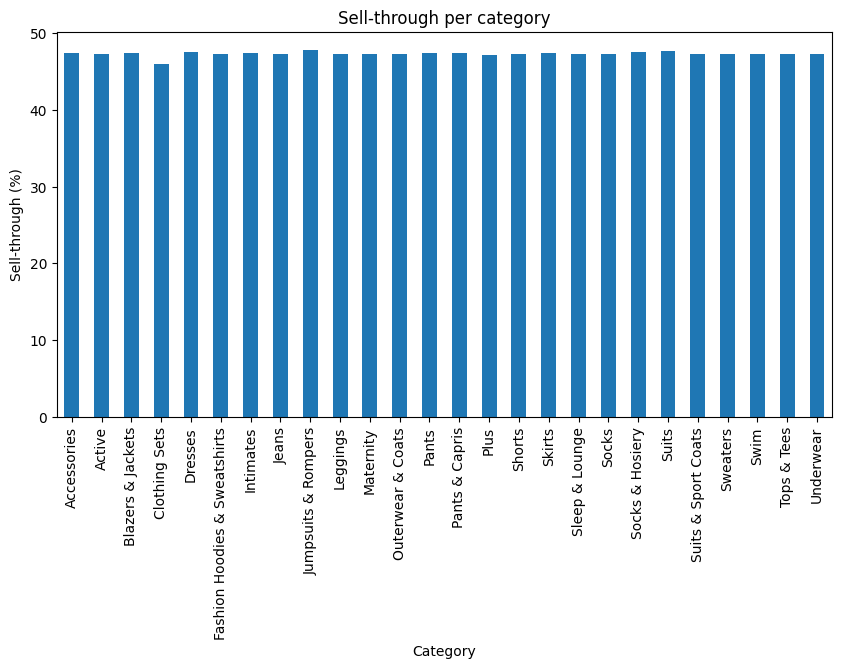

Categories with highest sell-through (%):
category
Jumpsuits & Rompers    47.79
Suits                  47.73
Socks & Hosiery        47.59
Dresses                47.54
Skirts                 47.48
Name: sold_at, dtype: float64

Categories with lowest sell-through (%):
category
Clothing Sets    46.05
Plus             47.22
Tops & Tees      47.24
Sweaters         47.25
Swim             47.26
Name: sold_at, dtype: float64


In [26]:
#sell_through per category 
sell_through_category = (
    df_real.groupby('category')['sold_at']
    .apply(lambda x: x.notna().mean())
)

sell_through_category_pct = (sell_through_category * 100).round(2)
sell_through_category_pct.plot(kind='bar', figsize=(10,5))
plt.title("Sell-through per category")
plt.xlabel("Category")
plt.ylabel("Sell-through (%)")
plt.show()

print("Categories with highest sell-through (%):")
print(sell_through_category_pct.sort_values(ascending=False).head())
print("\nCategories with lowest sell-through (%):")
print(sell_through_category_pct.sort_values(ascending=True).head())

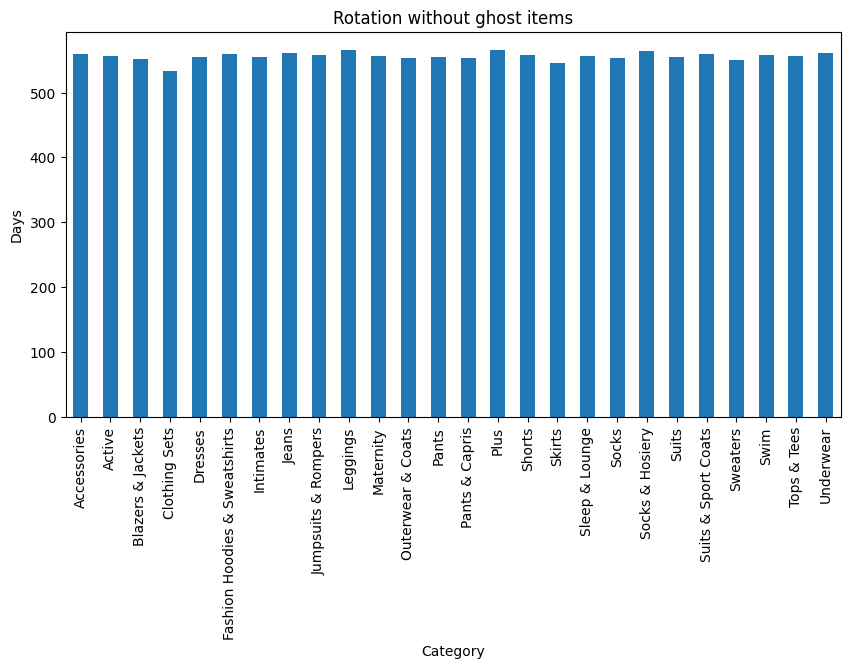

Categories with higher rotation (Days):
category
Leggings           565.346681
Plus               565.193641
Socks & Hosiery    564.149808
Jeans              560.496817
Underwear          560.301771
Name: days_in_inventory_total, dtype: float64

Categories with lower rotation (Days):
category
Clothing Sets        533.032558
Skirts               545.879367
Sweaters             549.593182
Blazers & Jackets    551.422331
Pants & Capris       553.347173
Name: days_in_inventory_total, dtype: float64


In [27]:
#rotation 
rotation_real = (
    df_real.groupby('category')['days_in_inventory_total'].mean())


rotation_real.plot(kind='bar', figsize=(10,5))
plt.title("Rotation without ghost items")
plt.xlabel("Category")
plt.ylabel("Days")
plt.show()

print("Categories with higher rotation (Days):")
print(rotation_real.sort_values(ascending=False).head())
print("\nCategories with lower rotation (Days):")
print(rotation_real.sort_values(ascending=True).head())

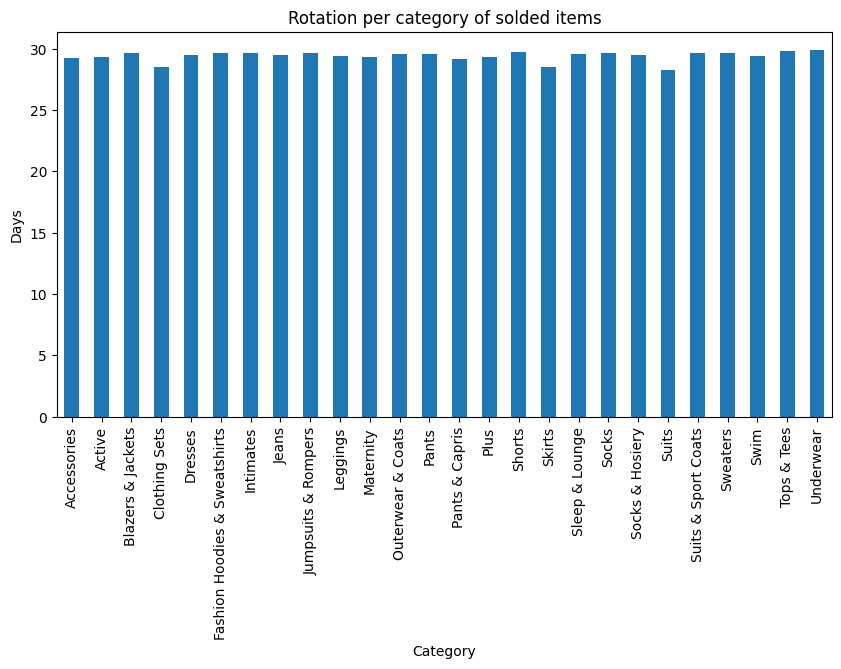

Categories with higher rotation only for sold items (days):
category
Underwear                        29.883407
Tops & Tees                      29.796730
Shorts                           29.700552
Socks                            29.691131
Fashion Hoodies & Sweatshirts    29.684040
Name: days_in_inventory_sold, dtype: float64

Categories with lower rotation onlyfor sold items (days):
category
Suits             28.291397
Clothing Sets     28.479798
Skirts            28.546837
Pants & Capris    29.144688
Accessories       29.252979
Name: days_in_inventory_sold, dtype: float64


In [28]:
#rotation per sold category 
rotation_sold_category = (
    df_real.groupby('category')['days_in_inventory_sold'].mean()
)
rotation_sold_category.plot(kind='bar', figsize=(10,5))
plt.title("Rotation per category of solded items")
plt.xlabel("Category")
plt.ylabel("Days")
plt.show()

print("Categories with higher rotation only for sold items (days):")
print(rotation_sold_category.sort_values(ascending=False).head())
print("\nCategories with lower rotation onlyfor sold items (days):")
print(rotation_sold_category.sort_values(ascending=True).head())

**Items performance**

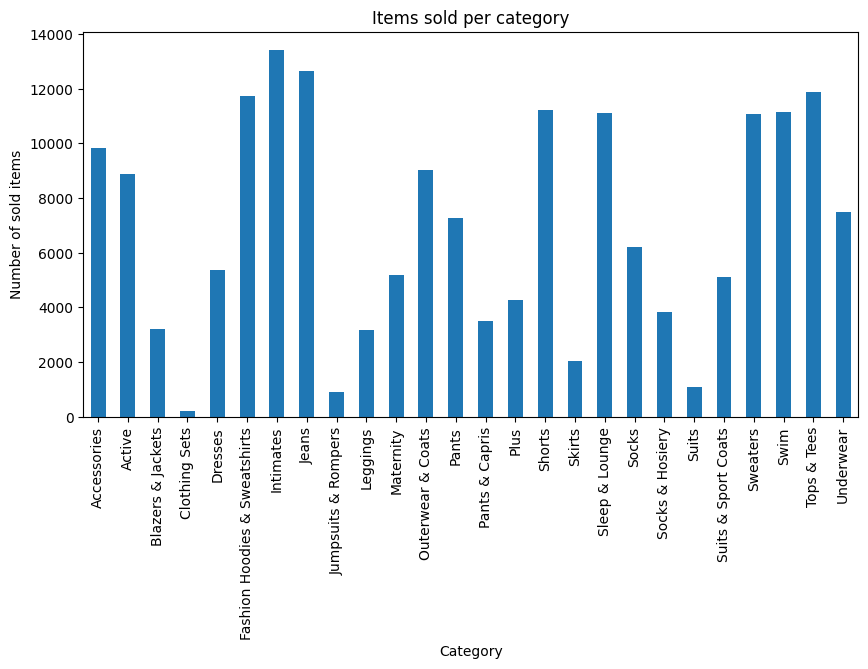

Most sold items:
category
Intimates                        13407
Jeans                            12633
Tops & Tees                      11866
Fashion Hoodies & Sweatshirts    11742
Shorts                           11234
dtype: int64

Least sold items:
category
Clothing Sets           198
Jumpsuits & Rompers     920
Suits                  1081
Skirts                 2039
Leggings               3176
dtype: int64


In [29]:
#item sold per category 

item_sold_category = (
    df_real[df_real['sold_at'].notna()]
    .groupby('category')
    .size()
)

item_sold_category.plot(kind='bar', figsize=(10,5))
plt.title("Items sold per category")
plt.xlabel("Category")
plt.ylabel("Number of sold items")
plt.show()

print("Most sold items:")
print(item_sold_category.sort_values(ascending=False).head())
print("\nLeast sold items:")
print(item_sold_category.sort_values(ascending=True).head())

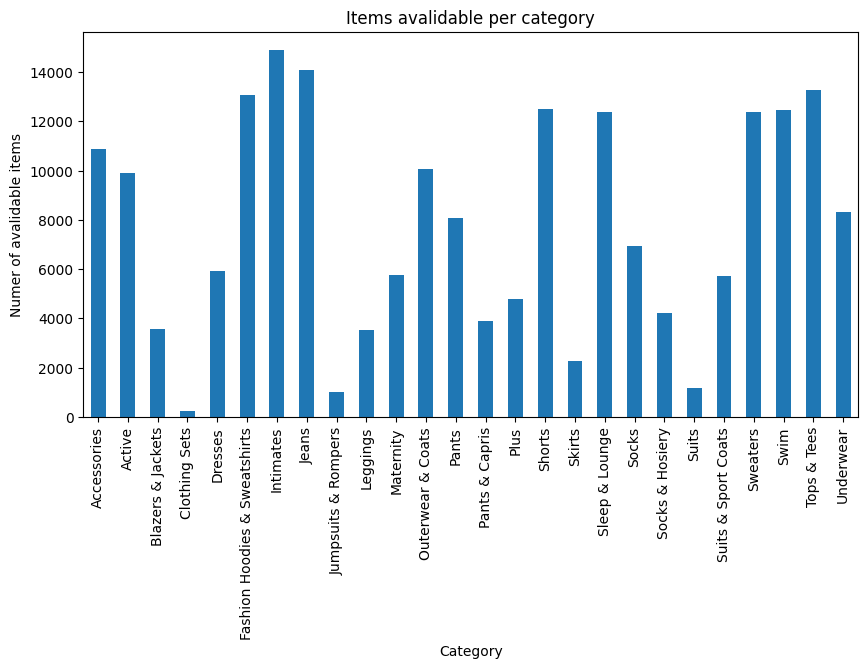

Most avalidable items per category:
category
Intimates                        14885
Jeans                            14069
Tops & Tees                      13253
Fashion Hoodies & Sweatshirts    13054
Shorts                           12496
dtype: int64

Least avalidable items per category:
category
Clothing Sets           232
Jumpsuits & Rompers    1005
Suits                  1184
Skirts                 2255
Leggings               3542
dtype: int64


In [43]:
#Items avalidable per category 

Items_avalidable_category = (
    df_real[df_real['sold_at'].isna()]
    .groupby('category')
    .size()
)

Items_avalidable_category.plot(kind='bar', figsize=(10,5))
plt.title("Items avalidable per category")
plt.xlabel("Category")
plt.ylabel("Numer of avalidable items")
plt.show()

print("Most avalidable items per category:")
print(Items_avalidable_category.sort_values(ascending=False).head())
print("\nLeast avalidable items per category:")
print(Items_avalidable_category.sort_values(ascending=True).head())

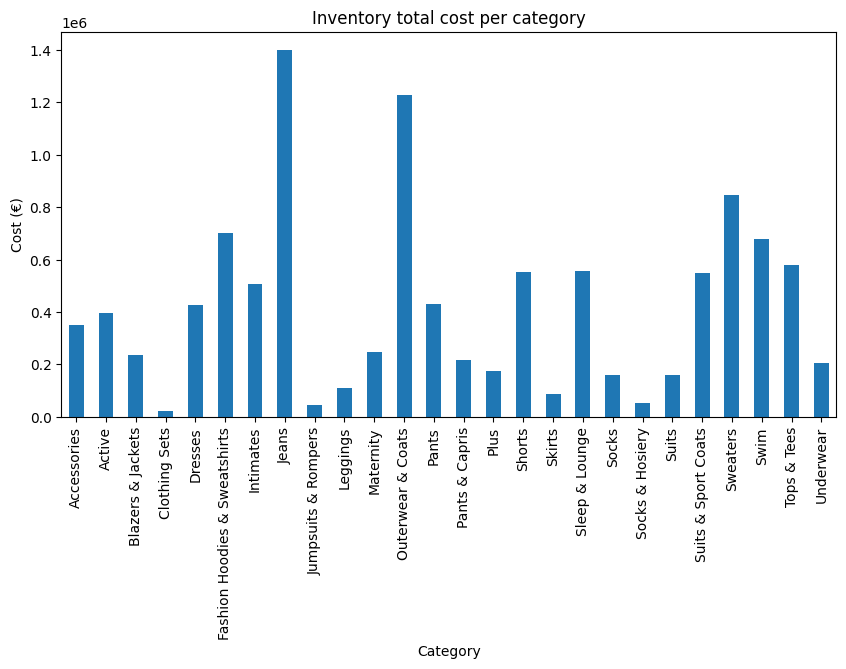

Categories with highest mean cos (€):
category
Jeans                            1399231.26
Outerwear & Coats                1229378.73
Sweaters                          846137.46
Fashion Hoodies & Sweatshirts     700815.13
Swim                              679867.06
Name: cost, dtype: float64

Categories with lowest mean cost (€):
category
Clothing Sets           21744.73
Jumpsuits & Rompers     45253.81
Socks & Hosiery         54412.90
Skirts                  86916.54
Leggings               109075.48
Name: cost, dtype: float64


In [46]:
#inventory total cost per category 
inventory_total_cost_category = (df_real.groupby('category')['cost'].sum())

inventory_total_cost_category.plot(kind='bar', figsize=(10,5))
plt.title("Inventory total cost per category")
plt.xlabel("Category")
plt.ylabel("Cost (€)")
plt.show()

print("Categories with highest mean cos (€):")
print(inventory_total_cost_category.sort_values(ascending=False).head())
print("\nCategories with lowest mean cost (€):")
print(inventory_total_cost_category.sort_values(ascending=True).head())

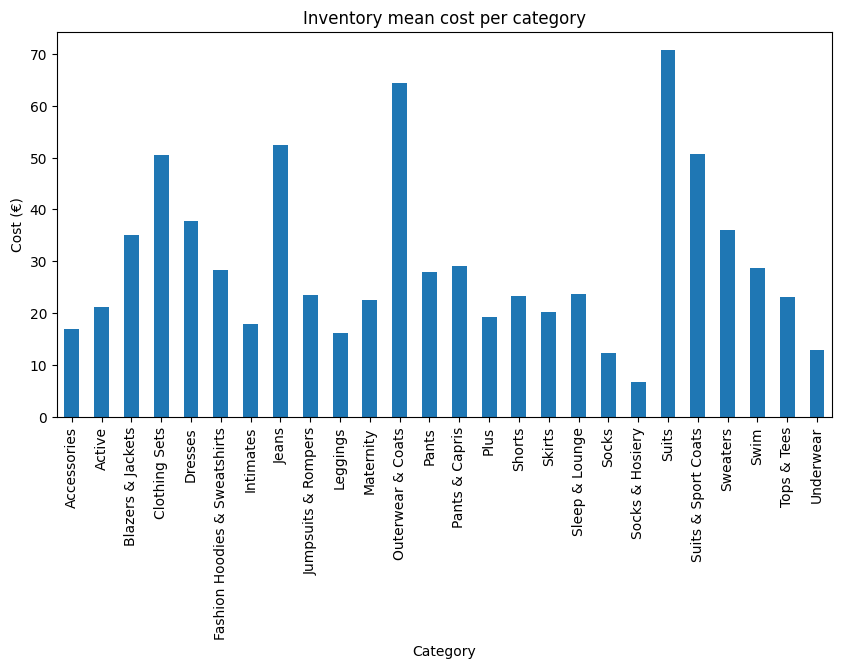

Categories with highest mean cost (€):
category
Suits                  70.722605
Outerwear & Coats      64.351902
Jeans                  52.401740
Suits & Sport Coats    50.664884
Clothing Sets          50.569140
Name: cost, dtype: float64

Categories with lowest mean cost (€):
category
Socks & Hosiery     6.736771
Socks              12.261442
Underwear          12.907242
Leggings           16.236302
Accessories        16.914309
Name: cost, dtype: float64


In [30]:
#inventory mean cost per category 

inventory_mean_cost_category = (
    df_real.groupby('category')['cost'].mean()
)

inventory_mean_cost_category.plot(kind='bar', figsize=(10,5))
plt.title("Inventory mean cost per category")
plt.xlabel("Category")
plt.ylabel("Cost (€)")
plt.show()

print("Categories with highest mean cost (€):")
print(inventory_mean_cost_category.sort_values(ascending=False).head())
print("\nCategories with lowest mean cost (€):")
print(inventory_mean_cost_category.sort_values(ascending=True).head())

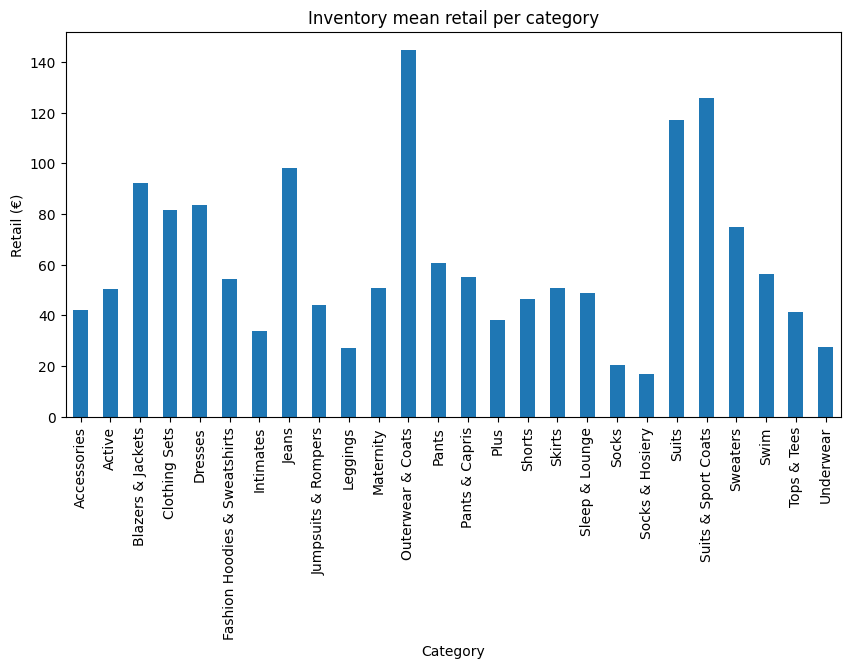

Categories with highest mean retail value (€):
category
Outerwear & Coats      144.681524
Suits & Sport Coats    125.997963
Suits                  116.965055
Jeans                   97.995466
Blazers & Jackets       92.117717
Name: product_retail_price, dtype: float64

Categories with lowest mean retail value (€):
category
Socks & Hosiery    16.723158
Socks              20.369435
Leggings           27.091173
Underwear          27.423247
Intimates          33.714888
Name: product_retail_price, dtype: float64


In [31]:
#inventory retail per category 
inventory_retail_category_mean = (
    df_real.groupby('category')['product_retail_price'].mean())

inventory_retail_category_mean.plot(kind='bar', figsize=(10,5))
plt.title("Inventory mean retail per category")
plt.xlabel("Category")
plt.ylabel("Retail (€)")
plt.show()

print("Categories with highest mean retail value (€):")
print(inventory_retail_category_mean.sort_values(ascending=False).head())
print("\nCategories with lowest mean retail value (€):")
print(inventory_retail_category_mean.sort_values(ascending=True).head())

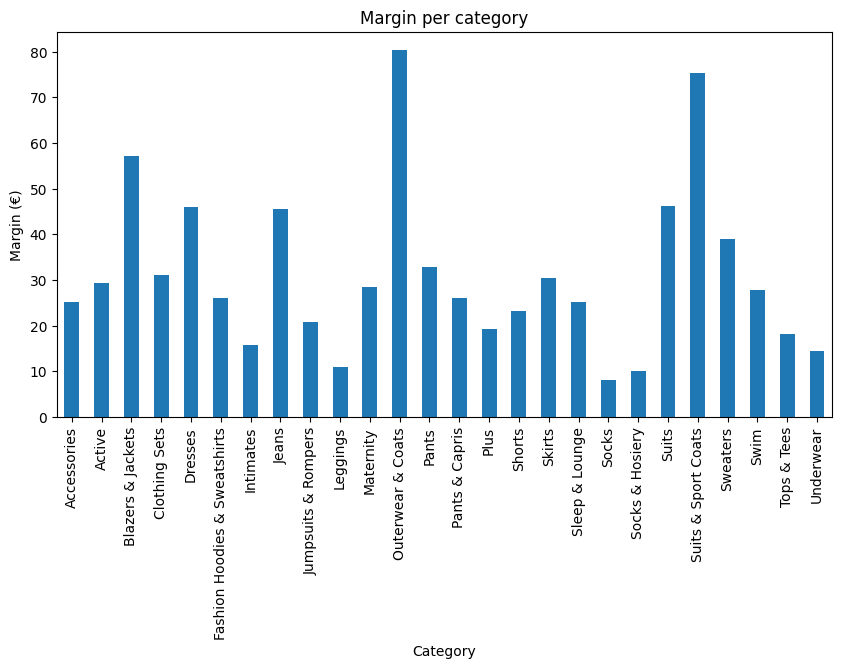

Categories with highest margin (€):
category
Outerwear & Coats      80.329623
Suits & Sport Coats    75.333079
Blazers & Jackets      57.121924
Suits                  46.242450
Dresses                46.049055
Name: margin, dtype: float64

Categories with lowest margin (€):
category
Socks               8.107992
Socks & Hosiery     9.986387
Leggings           10.854870
Underwear          14.516005
Intimates          15.800270
Name: margin, dtype: float64


In [32]:
#Margin per category
df_real.loc[:, 'margin'] = df_real['product_retail_price'] - df_real['cost']
margin_category = df_real.groupby('category')['margin'].mean()

margin_category.plot(kind='bar', figsize=(10,5))
plt.title("Margin per category")
plt.xlabel("Category")
plt.ylabel("Margin (€)")
plt.show()

print("Categories with highest margin (€):")
print(margin_category.sort_values(ascending=False).head())
print("\nCategories with lowest margin (€):")
print(margin_category.sort_values(ascending=True).head())

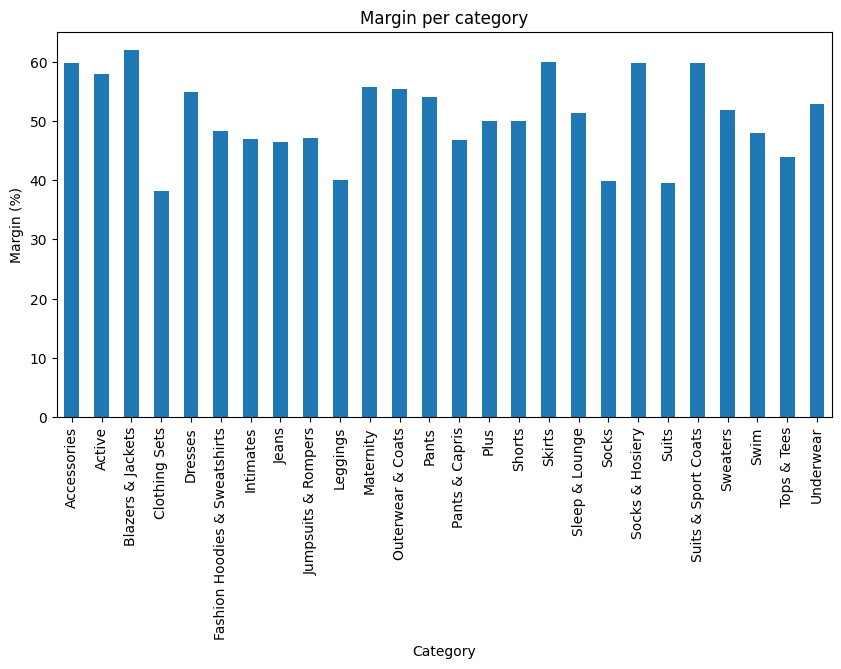

Categories with highest margin (%):
category
Blazers & Jackets      62.013126
Skirts                 60.040275
Suits & Sport Coats    59.923743
Accessories            59.908925
Socks & Hosiery        59.835662
Name: margin_pct, dtype: float64

Categories with lowest margin (%):
category
Clothing Sets    38.144199
Suits            39.491459
Socks            39.804536
Leggings         40.059092
Tops & Tees      44.004782
Name: margin_pct, dtype: float64


In [33]:
# Margin % per category
df_real.loc[:, 'margin_pct'] = df_real['margin'] / df_real['product_retail_price'] *100
margin_pct_category = df_real.groupby('category')['margin_pct'].mean()

margin_pct_category.plot(kind='bar', figsize=(10,5))
plt.title("Margin per category")
plt.xlabel("Category")
plt.ylabel("Margin (%)")
plt.show()

print("Categories with highest margin (%):")
print(margin_pct_category.sort_values(ascending=False).head())
print("\nCategories with lowest margin (%):")
print(margin_pct_category.sort_values(ascending=True).head())

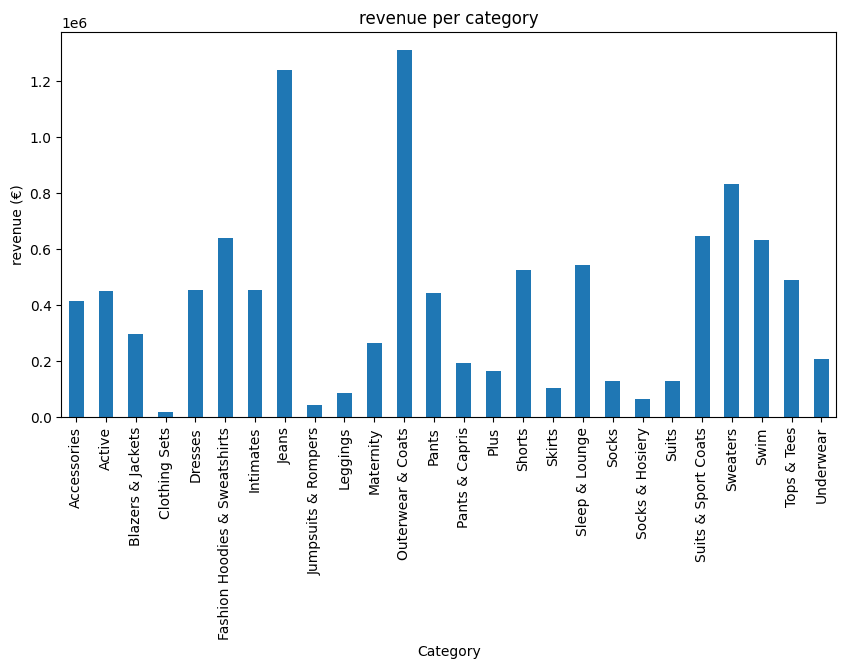

Categories with highest revenue (€):
category
Outerwear & Coats                1309026.46
Jeans                            1237843.92
Sweaters                          831070.18
Suits & Sport Coats               645093.81
Fashion Hoodies & Sweatshirts     639427.11
Name: product_retail_price, dtype: float64

Categories with lowest revenue (€):
category
Clothing Sets           16212.53
Jumpsuits & Rompers     41257.99
Socks & Hosiery         64319.61
Leggings                86101.04
Skirts                 103223.93
Name: product_retail_price, dtype: float64


In [34]:
#Revenue per category

revenue_category = df_real[df_real['sold_at'].notna()].groupby('category')['product_retail_price'].sum()

revenue_category.plot(kind='bar', figsize=(10,5))
plt.title("revenue per category")
plt.xlabel("Category")
plt.ylabel("revenue (€)")
plt.show()

print("Categories with highest revenue (€):")
print(revenue_category.sort_values(ascending=False).head())
print("\nCategories with lowest revenue (€):")
print(revenue_category.sort_values(ascending=True).head())

**What-If Analysis**

In [ ]:
df_real['profit_real'] = df_real['sale_price'] - df_real['cost']

df_real['margin_real_pct'] = (df_real['profit_real'] / df_real['sale_price']) * 100

In [36]:
average_margin = df_real['margin_real_pct'].mean().round(2)
print("Average profit margin (%):", average_margin, "%")

Average profit margin (%): 51.04 %


In [37]:
df_real['profit_50pct'] = df_real['sale_price'] * 0.5104

In [38]:
df_real['profit_avg'] = df_real['sale_price'] * (average_margin / 100)

In [39]:
print("Total real profit:", df_real['profit_real'].sum().round(2))

Total real profit: 5573703.49


In [40]:
print("Average profit per item (real):", df_real['profit_real'].mean().round(2))
print("Average profit per item (what-if):", df_real['profit_avg'].mean().round(2))

Average profit per item (real): 30.82
Average profit per item (what-if): 30.32


In [41]:
summary = pd.DataFrame({'Real Profit': [df_real['profit_real'].sum().round(2)], 'What-if (Avg Margin)': [df_real['profit_avg'].sum().round(2)]})

print(summary)

   Real Profit  What-if (Avg Margin)
0   5573703.49            5483605.85


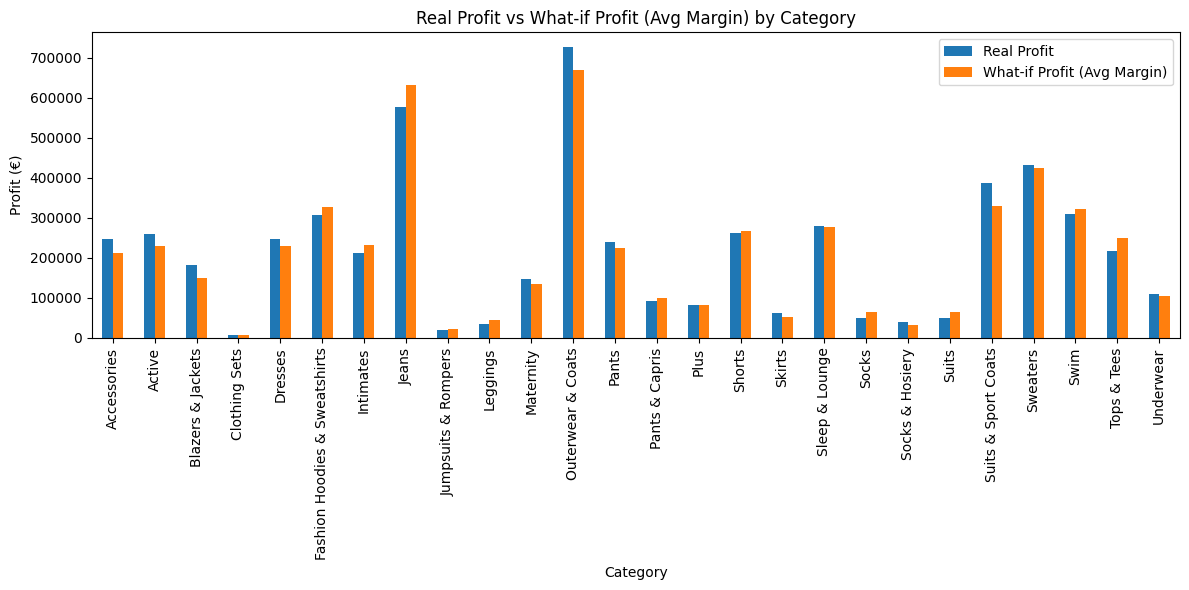

                               Real Profit  What-if Profit (Avg Margin)
category                                                               
Outerwear & Coats                726877.39                    668127.10
Jeans                            575948.37                    631795.54
Sweaters                         430934.88                    424178.22
Suits & Sport Coats              385678.42                    329255.88
Swim                             310046.26                    322343.95
Fashion Hoodies & Sweatshirts    307152.54                    326363.60
Sleep & Lounge                   279880.80                    277365.99
Shorts                           261609.46                    267161.16
Active                           260625.94                    229128.56
Dresses                          248133.04                    230260.33
Accessories                      247654.47                    211014.57
Pants                            238210.56                    22

In [42]:
profit_by_category = df_real.groupby('category').agg({
    'profit_real': 'sum',
    'profit_avg': 'sum'
}).round(2)

profit_by_category.columns = ['Real Profit', 'What-if Profit (Avg Margin)']

profit_by_category.plot(kind='bar', figsize=(12,6), title='Real Profit vs What-if Profit (Avg Margin) by Category')

plt.xlabel("Category")
plt.ylabel("Profit (€)")
plt.tight_layout()
plt.show()

print(profit_by_category.sort_values('Real Profit', ascending=False))

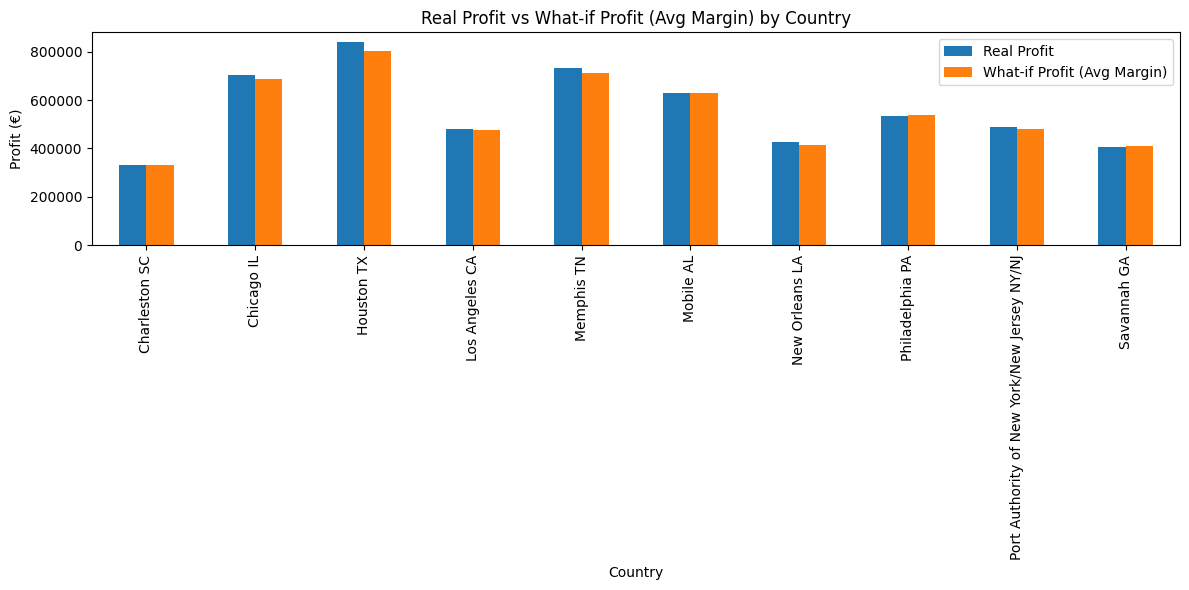

                                             Real Profit  \
center_name                                                
Houston TX                                     838361.10   
Memphis TN                                     731570.86   
Chicago IL                                     703181.29   
Mobile AL                                      631054.85   
Philadelphia PA                                535837.71   
Port Authority of New York/New Jersey NY/NJ    489602.52   
Los Angeles CA                                 481012.61   
New Orleans LA                                 426030.54   
Savannah GA                                    407020.14   
Charleston SC                                  330031.86   

                                             What-if Profit (Avg Margin)  
center_name                                                               
Houston TX                                                     803782.92  
Memphis TN                                            

In [43]:
profit_by_country = df_real.groupby('center_name').agg({
    'profit_real': 'sum',
    'profit_avg': 'sum'
}).round(2)

profit_by_country.columns = ['Real Profit', 'What-if Profit (Avg Margin)']

profit_by_country.plot(
    kind='bar',
    figsize=(12,6),
    title='Real Profit vs What-if Profit (Avg Margin) by Country'
)

plt.xlabel("Country")
plt.ylabel("Profit (€)")
plt.tight_layout()
plt.show()

print(profit_by_country.sort_values('Real Profit', ascending=False))

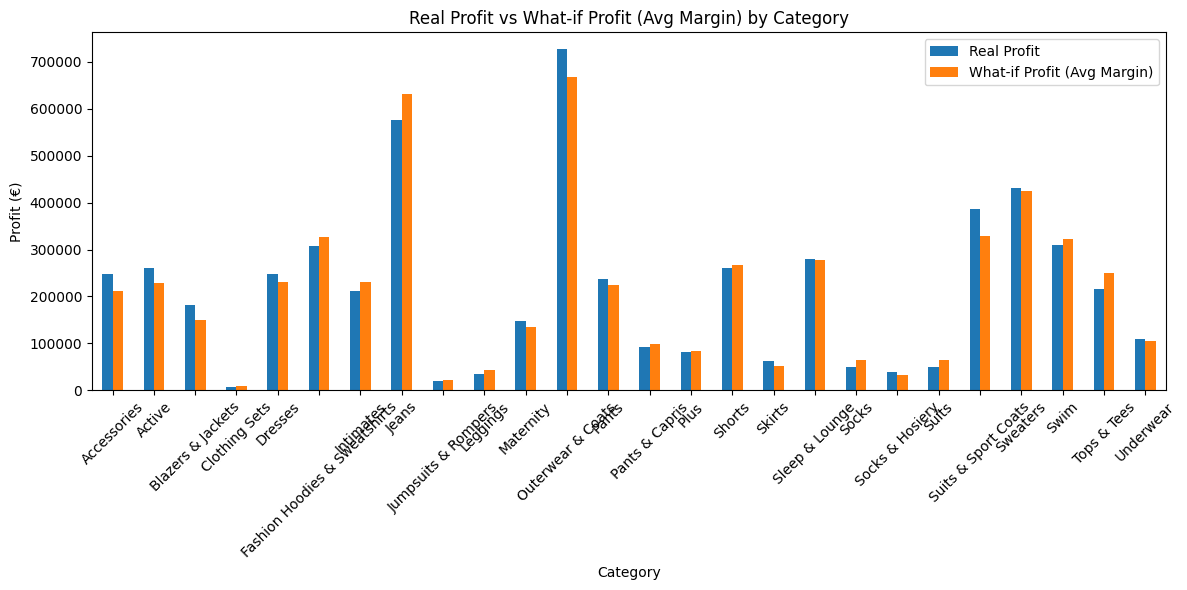

In [44]:
profit_by_category.plot(kind='bar', figsize=(12,6), title='Real Profit vs What-if Profit (Avg Margin) by Category')

plt.xlabel("Category")
plt.ylabel("Profit (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The analysis shows that approximately 22% of the items in the dataset are “ghost items,” meaning they are not traceable and can only be verified through a physical inventory check. Their presence distorts inventory metrics, making the average stock age appear to be nearly two years.
Once these items are removed, the actual average stock age drops to just over one year, while for sold items only, the average time spent in inventory is 36 days.
This strong divergence suggests an underlying warehouse management issue, likely related to an incomplete application of the FIFO (First In, First Out) principle, resulting in the accumulation of obsolete stock and inefficient rotation.